# PDF Sampling: Inverse transform sampling 

- In many cases, we want to sample a PDF (probability density function). Only a few well define PDF like Gaussian has a 'generator function'. 

- We can sample a PDF by inversing it, if we can inverse the CDF (cumulative density function). 

- Steps: 
    + Calculate CDF $F(x) = \int_{-\infty}^{x} f(x) dx$
    + Calculate inverse-CDF $F^{-1}(p), p \in (0, 1)$
        + Generate uniform random variable $u \in [0, 1]$
        + Calculate $x = F^{-1}(u)$
        

Let's try it using a Plummer distribution. According to <a href='https://en.wikipedia.org/wiki/Plummer_model'>Wikipedia</a>, Plummer 3-dimensional density profile is given by

$$ \rho_{P}(r) = \left( \frac{3M}{4\pi a^3} \right) \left( 1 + \left(\frac{r}{a}\right)^2 \right)^{-5/2} $$

$r = $ radial distance from center

$a = $ Plummer radius

The mass enclosed within radius $r$ is given by

$ m(r) = \int_{0}^{r} 4 \pi r^2 \rho(r) dr = \int_{0}^{r} \frac{3 r^2}{a^3} \left[ 1 + \left(\frac{r}{a}\right)^2 \right]^{-5/2} dr $.

With $M = 1$ that equation become our CDF. Plummer PDF by definition then can be written as

$ f(r | a) = \frac{3 r^2}{a^3}\left[1 + \left(\frac{r}{a}\right)^2\right]^{-5/2} $

We can get CDF by integration, 

$ F(r | a) = m(r) = \frac{(r/a)^{3}}{\left[ 1 + (r/a)^{2} \right]^{3/2}}$

and also find the inverse-CDF

$ F^{-1}(m | a) = r(m) = a\left( m^{-2/3} - 1\right)^{-1/2}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
def plummer(r, a=1.0, arg='ppf'):
    if arg == 'density': 
        return (3/(4*np.pi*a*a*a)) * np.power((1 + r*r/(a*a)), -5./2)
    elif arg == 'pdf': 
        return (3*r*r/(a*a*a)) * np.power((1 + r*r/(a*a)), -5./2.)
    elif arg == 'cdf': 
        x = r/a
        return x*x*x * np.power((1 + x*x), -3./2.)
    elif arg == 'ppf': 
        return a / np.sqrt(np.power(r, -2./3.) - 1.0) # r = m
    else:
        print('Error arg')
        return None

## Let's plot our functions

In [3]:
def plot_plummer(a=1, arg='pdf', rmin=0.0, rmax=10.0, N=1000, xlabel=r'$r$', ylabel=r'$f(r|a)$'):
    r = np.linspace(rmin, rmax, N)
    f = plummer(r, a, arg)
    plt.plot(r, f)
    plt.title(arg) 
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

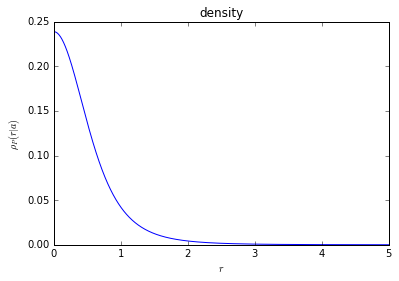

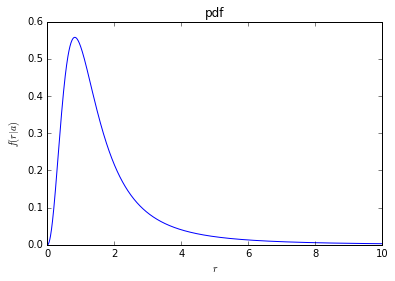

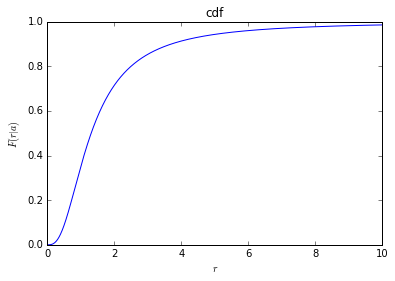

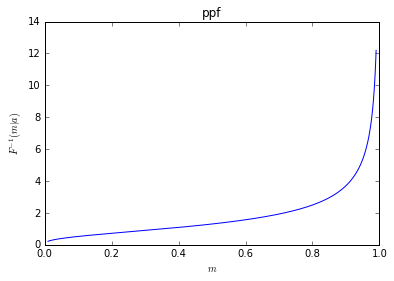

In [4]:
plot_plummer(1.0, 'density', rmax=5.0, xlabel=r'$r$', ylabel=r'$\rho_{P}(r|a)$')
plot_plummer() # pdf
plot_plummer(1.0, 'cdf', xlabel=r'$r$', ylabel=r'$F(r|a)$')
plot_plummer(1.0, 'ppf',rmin=0.01, rmax=0.99, xlabel=r'$m$', ylabel=r'$F^{-1}(m|a)$')

## Let's do inverse transform sampling

We want to generate samples that follow Plummer distribution

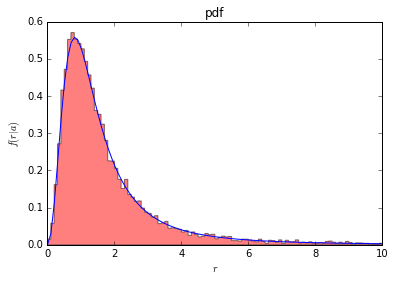

In [5]:
np.random.seed(7)

a = 1.0
npoints = 10000
rmin=0.0
rmax=10.0
nbins=100
rsample = plummer(np.random.random(npoints), a, 'ppf')

plt.hist(rsample, bins=nbins, normed=True, range=[rmin, rmax], color='red', histtype='stepfilled', alpha=0.5);
plot_plummer(a, 'pdf', rmin, rmax, nbins)
plt.show()

### Let's make a star cluster

In [6]:
a = 1.0
npoints = 1000
rmin=0.0
rmax=10.0

# generate random position in spherical coord
r = plummer(np.random.uniform(0, 1, npoints), a, 'ppf')
phi = np.random.uniform(0, 2*np.pi, npoints)
theta = np.arccos(np.random.uniform(-1, 1, npoints))

# convert to cartesian
x = r*np.sin(theta)*np.cos(phi)
y = r*np.sin(theta)*np.sin(phi)
z = r*np.cos(theta)

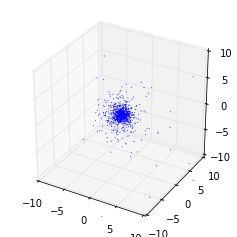

In [7]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')

ax.scatter(x, y, z, s=1, linewidth=0, c='b')
ax.set_xlim(-rmax, rmax); ax.set_ylim(-rmax, rmax); ax.set_zlim(-rmax, rmax)
plt.show()

This result may be used as 'initial position' in <b>toy model</b> of a star cluster, how about the 'initial velocity'? :)

## Let's record sampling process (an animation)

In [22]:
GOLDEN_RATIO = 0.5*(1. + np.sqrt(5))

def plot_sample(msample, a = 1, rmin=0, rmax=10, N=1000, bins=50, write=False, filename='inverseTS_plot.png', trace=False):
    nRow = 2
    nCol = 1
    xSize = 4.5
    ySize = float(nRow)*xSize/GOLDEN_RATIO
    npoints=len(msample)
    
    fig = plt.figure(figsize=(xSize, ySize))
    gs = gridspec.GridSpec(nRow, nCol)
    ofile = '/home/ridlo/project/mcmc/inverseTS_plot/' + filename
    
    r = np.linspace(rmin, rmax, N)
    f = plummer(r, a, 'cdf')
    axCDF = plt.subplot(gs[0, 0])
    axCDF.plot(r, f)
    
    axCDF.hist(msample, bins=bins, orientation='horizontal', normed=1, color='green', histtype='stepfilled', alpha=0.5, linewidth=0.0)
    if trace:
        sample = msample[-1] # last sample 
        ppfsample = plummer(sample, a, 'ppf')
        axCDF.axvline(x=ppfsample, ymin=0, ymax=sample, c='k')
        axCDF.axhline(y=sample, xmin=0, xmax=(ppfsample-rmin)/(rmax-rmin), c='k')
        axCDF.plot(ppfsample, sample, 'r.')
    
    text = r'$n_{sample} = $'+str(npoints)
    axCDF.annotate(text, xy=(0.6, 0.9), xycoords='axes fraction', ha='left', va='top')
    
    f = plummer(r, a, 'pdf')
    axPDF = plt.subplot(gs[1, 0])
    axPDF.plot(r, f)
    rsample = plummer(msample, a, 'ppf')
    axPDF.hist(rsample, bins=bins, normed=1, range=[rmin, rmax], color='red', histtype='stepfilled', alpha=0.5, linewidth=0.0);
    
    axCDF.set_xlim(rmin,rmax)
    axCDF.set_ylim(0,1)
    axPDF.set_xlim(rmin,rmax)
    axPDF.set_ylim(0,0.6)
    
    if write:
        plt.savefig(ofile, bbox_inches='tight', dpi=300); plt.close()
    else:
        plt.show(); plt.close()

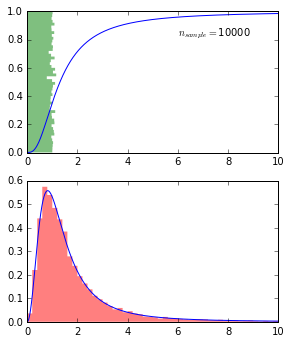

In [23]:
sample = np.random.random(10000)
plot_sample(msample=sample)

In [27]:
# make an animation
npoints = 1000
sample = np.random.random(npoints)
divisor = 10

In [28]:
for i in range(npoints):
    plot_sample(msample=sample[0:i+1], 
                write=True, 
                filename='plotsample_nsamp_{0:04d}.png'.format(i), 
                trace=True)
    if (((i+1) % divisor) == 0):
        print ".",

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


In [29]:
from IPython.display import YouTubeVideo

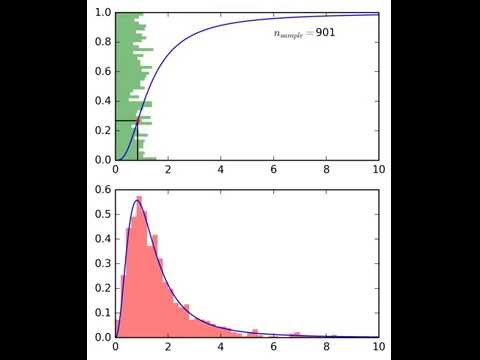

In [30]:
YouTubeVideo("7WR9tnjzhq4")

### References

- SEAYAC Workshop, *MC methods in astronomy*, Tri L. Astraatmadja (MPIA Heidelberg)
    Krabi, 4 December 2015
- <a href="http://en.wikipedia.org/wiki/Plummer_model">Wikipedia</a>
- <a href="http://stackoverflow.com/questions/28434765/how-to-randomly-distribute-n-masses-such-that-they-follow-a-plummer-density-dis">Stackoverflow</a>
